In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

import torch
import torch.nn as nn

from networks.ResNet_3D_CPM import Resnet18, DetectionPostprocess
from utils.box_utils import nms_3D
from logic.utils import load_states, load_model

# model_path = './save/best_froc_2_recall.pth'
model_path = './save/[2024-04-14-0127]_New_pt_fpnElanV1_elanV5PreBV3_2_dwV1_bs3n5Acc2_FP0507_01502_numHard200_actSiLU/best/best_froc_2_recall.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = load_model(model_path)
model = model.to(device)

# model = Resnet18()
# load_states(model_path, device, model)

In [34]:
# module_name = []
# features_in_hook = []
# features_out_hook = []
features = {'names': [], 'in': [], 'out': []}

def hook_wrapper(name: str):
    def hook(module, fea_in, fea_out):
        features['names'].append(name)
        features['in'].append(fea_in)
        features['out'].append(fea_out)
        return None
    return hook

for name, module in model.named_modules():
    if name != 'detection_loss' and name != 'detection_loss':
        module.register_forward_hook(hook_wrapper(name))

In [3]:
from dataload.dataset import TrainDataset, DetDataset
import transform as transform
import torchvision
from torch.utils.data import DataLoader
from dataload.utils import get_image_padding_value
from config import IMAGE_SPACING
from dataload.crop import InstanceCrop
from dataload.collate import train_collate_fn

def build_train_augmentation(crop_size: Tuple[int, int, int]):
    rot_zy = (crop_size[0] == crop_size[1] == crop_size[2])
    rot_zx = (crop_size[0] == crop_size[1] == crop_size[2])
        
    transform_list_train = [transform.RandomFlip(p=0.5, flip_depth=True, flip_height=True, flip_width=True)]
    transform_list_train.append(transform.RandomRotate90(rot_xy=True, rot_xz=rot_zx, rot_yz=rot_zy))
    transform_list_train.append(transform.CoordToAnnot())
                            
    train_transform = torchvision.transforms.Compose(transform_list_train)
    return train_transform

crop_size = [96, 96, 96]

data_norm_method = 'none'
pad_value = get_image_padding_value(data_norm_method, use_water=False)
train_transform = build_train_augmentation(crop_size)
train_set = './data/pretrained_train.txt'
min_d = 1
min_size = 5
use_bg = False
batch_size = 1

num_samples = 5
overlap_ratio = 0.25
tp_ratio = 0.75

overlap_size = (np.array(crop_size) * overlap_ratio).astype(np.int32).tolist()
rand_trans = [int(s * 2/3) for s in overlap_size]
rand_rot = [30, 0, 0]
crop_fn_train = InstanceCrop(crop_size=crop_size, overlap_ratio=overlap_ratio, tp_ratio=tp_ratio, rand_trans=rand_trans, rand_rot=rand_rot,
                            sample_num=num_samples, instance_crop=True)
mmap_mode = None
train_dataset = TrainDataset(series_list_path = train_set, crop_fn = crop_fn_train, image_spacing=IMAGE_SPACING, transform_post = train_transform, 
                                min_d=min_d, min_size = min_size, use_bg = use_bg, norm_method=data_norm_method, mmap_mode=mmap_mode)

train_loader = DataLoader(train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True,
                            collate_fn=train_collate_fn,
                            num_workers=1,
                            pin_memory=True,
                            drop_last=True, 
                            persistent_workers=True)

In [4]:
model.eval()
for i, sample in enumerate(train_loader):
    with torch.no_grad():
        image = sample['image'].to(device, non_blocking=True) # z, y, x
        output = model(image)
    break

In [35]:
model.eval()
with torch.no_grad():
    image = sample['image'].to(device, non_blocking=True) # z, y, x
    output = model(image)

In [36]:
print(len(features['names']), len(features['in']), len(features['out']))
print(features['names'])

305 305 305
['in_conv.stem1.conv', 'in_conv.stem1.norm', 'in_conv.stem1.act', 'in_conv.stem1', 'in_conv.stem2.conv', 'in_conv.stem2.norm', 'in_conv.stem2.act', 'in_conv.stem2', 'in_conv.conv0.conv', 'in_conv.conv0.norm', 'in_conv.conv0.act', 'in_conv.conv0', 'in_conv.conv1.conv', 'in_conv.conv1.norm', 'in_conv.conv1.act', 'in_conv.conv1', 'in_conv.conv2.conv', 'in_conv.conv2.norm', 'in_conv.conv2.act', 'in_conv.conv2', 'in_conv.trans.conv', 'in_conv.trans.norm', 'in_conv.trans.act', 'in_conv.trans', 'in_conv', 'in_dw.conv', 'in_dw.norm', 'in_dw.act', 'in_dw', 'block1.stem.res', 'block1.stem.conv1.conv', 'block1.stem.conv1.norm', 'block1.stem.conv1.act', 'block1.stem.conv1', 'block1.stem.conv2.conv', 'block1.stem.conv2.norm', 'block1.stem.conv2.act', 'block1.stem.conv2', 'block1.stem.se.avg_pool', 'block1.stem.se.fc.0', 'block1.stem.se.fc.1', 'block1.stem.se.fc.2', 'block1.stem.se.fc.3', 'block1.stem.se.fc', 'block1.stem.se', 'block1.stem.act', 'block1.stem', 'block1.conv0.res.conv', 'b

In [15]:
def get_out_feat(name, b_i):
    return features['out'][features['names'].index(name)][b_i]

bs_i = 4
block22_feat = get_out_feat('block22', bs_i)
# aspp3_feat = get_out_feat('block4.aspp3', bs_i)
# aspp_avg_feat = get_out_feat('block4.avg_conv', bs_i)
head_conv_s = get_out_feat('head.conv_s', bs_i)
head_conv_s_2 = get_out_feat('head.conv_s.2', bs_i)

# fpn_P3_2 = get_out_feat('fpn.P3_2', bs_i)
# block22_conv_1_conv2 = get_out_feat('block22.conv.1.conv2', bs_i)

In [37]:
head_conv_s = get_out_feat('head.conv_s', bs_i)
head_conv_s_2 = get_out_feat('head.conv_s.2', bs_i)
fpn_feat = get_out_feat('fpn', bs_i)

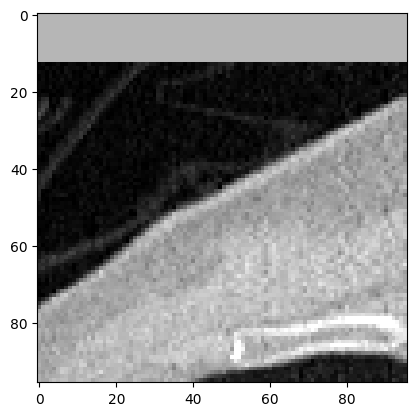

In [22]:
import matplotlib.pyplot as plt
z = 48
plt.imshow(image[bs_i, 0, z].cpu().numpy(), cmap='gray')

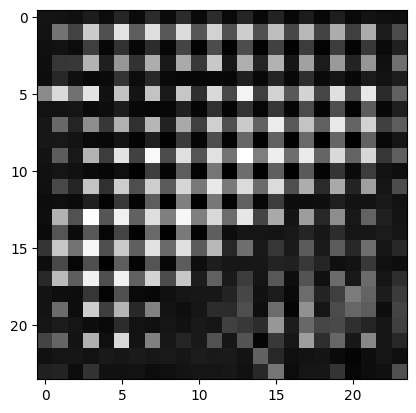

In [17]:
import matplotlib.pyplot as plt
c_i = 79
z_i = 21
plt.imshow(block22_feat[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

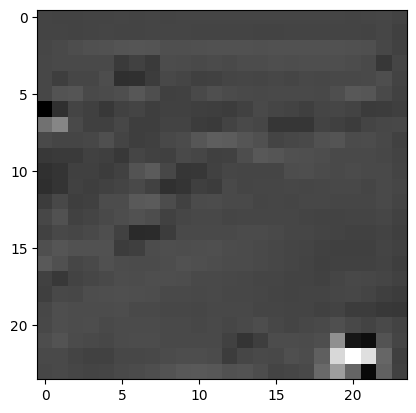

In [48]:
import matplotlib.pyplot as plt
c_i = 17
z_i = 12
plt.imshow(fpn_feat[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

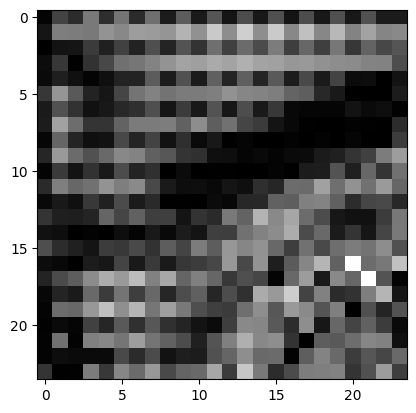

In [30]:
import matplotlib.pyplot as plt
c_i = 21
z_i = 21
plt.imshow(fpn_feat[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

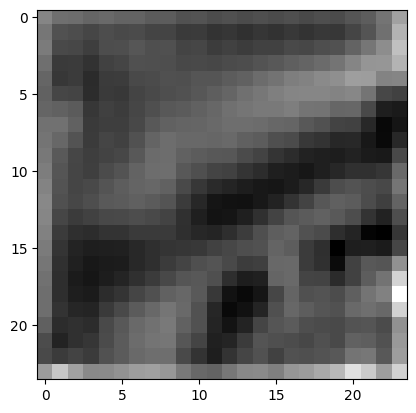

In [25]:
import matplotlib.pyplot as plt
c_i = 26
z_i = 21
plt.imshow(head_conv_s_2[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

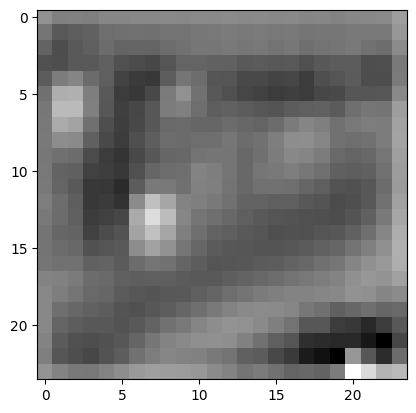

In [32]:
import matplotlib.pyplot as plt
c_i = 26
z_i = 12
plt.imshow(head_conv_s[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

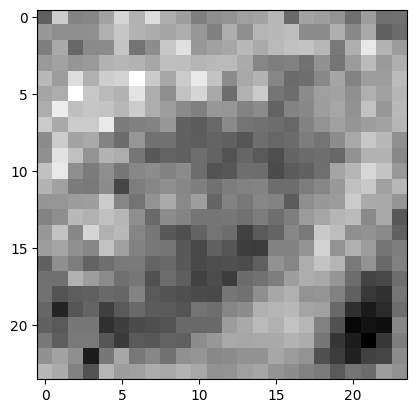

In [27]:
import matplotlib.pyplot as plt
c_i = 5
z_i = 12
plt.imshow(fpn_P3_2[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

In [28]:
import matplotlib.pyplot as plt
c_i = 26
z_i = 3
plt.imshow(aspp_avg_feat[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

IndexError: index 3 is out of bounds for dimension 1 with size 1

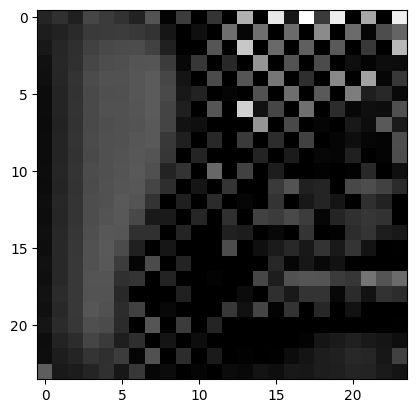

In [18]:
import matplotlib.pyplot as plt
c_i = 19
z_i = 20
plt.imshow(block22_feat[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

In [19]:
block22_feat[c_i, z_i, :, :]

tensor([[5.9483e-01, 7.9262e-01, 5.4519e-01, 1.1574e+00, 9.6494e-01, 8.2042e-01,
         5.5865e-01, 1.3604e+00, 5.6307e-02, 9.9339e-01, 0.0000e+00, 8.7364e-01,
         0.0000e+00, 2.8844e+00, 0.0000e+00, 3.7916e+00, 3.7923e-01, 4.1827e+00,
         9.6321e-01, 3.8976e+00, 0.0000e+00, 2.7504e+00, 0.0000e+00, 3.8890e+00],
        [4.8747e-01, 5.6050e-01, 6.8966e-01, 9.5624e-01, 9.6668e-01, 1.0127e+00,
         9.1599e-01, 8.3494e-01, 3.6406e-01, 0.0000e+00, 2.5303e-01, 0.0000e+00,
         1.8017e+00, 1.0835e-01, 1.8242e+00, 0.0000e+00, 1.7533e+00, 0.0000e+00,
         2.2833e+00, 0.0000e+00, 1.7520e+00, 1.1244e-01, 1.2624e+00, 1.6488e+00],
        [3.9698e-01, 6.3170e-01, 7.7247e-01, 1.0861e+00, 1.1773e+00, 1.2273e+00,
         1.2431e+00, 1.0725e+00, 5.4790e-01, 5.4707e-03, 0.0000e+00, 1.3941e+00,
         0.0000e+00, 3.2669e+00, 0.0000e+00, 1.7374e+00, 0.0000e+00, 1.5527e+00,
         0.0000e+00, 1.4682e+00, 1.7601e-03, 9.1958e-01, 0.0000e+00, 3.0179e+00],
        [2.8929e-01, 6.41

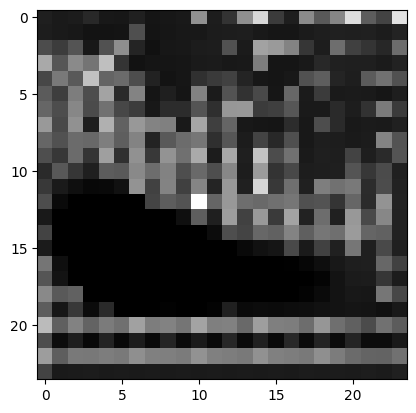

In [63]:
import matplotlib.pyplot as plt
c_i = 0
z_i = 10
plt.imshow(block22_se[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

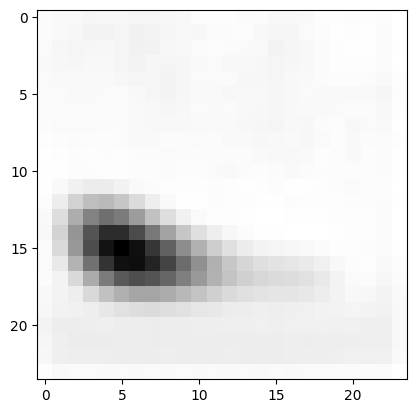

In [68]:
import matplotlib.pyplot as plt
c_i = 0
z_i = 10
plt.imshow(block22_conv_1_conv2[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

In [65]:
(block22_conv_1_conv2_norm[c_i, z_i, :, :] / block22_se[c_i, z_i, :, :])

tensor([[ 1.6641,  1.8168,  1.7261,  1.0159,  1.8168,  1.8168,  1.1804,  1.8168,
          1.8168,  1.8168,  0.3872,  1.8168,  1.0782,  0.3580,  0.2459,  0.7773,
          1.5142,  0.3470,  0.6414,  0.4247,  0.2541,  0.6258,  0.8206,  0.2818],
        [ 1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  0.3692,  1.8168,
          1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  1.8168,
          1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  1.8168],
        [ 0.6594,  0.6876,  0.4571,  1.6816,  0.5153,  0.2649,  0.7585,  1.8168,
          1.8168,  1.8168,  1.8168,  1.8168,  0.6516,  1.8168,  0.2931,  0.2345,
          0.2994,  0.8657,  1.8168,  0.5160,  0.9371,  1.1105,  1.3601,  0.5667],
        [ 0.2906,  0.5076,  0.2915,  0.3972,  0.2333,  0.7467,  1.8168,  1.8168,
          1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  1.8168,  0.3375,  1.8168,
          1.8168,  1.8168,  1.3113,  1.8168,  1.8168,  1.8168,  1.8168,  1.8168],
        [ 0.7125,  0.402

tensor([[0.2042, 0.1727, 0.1831, 0.2666, 0.1591, 0.1530, 0.2146, 0.1411, 0.1530,
         0.1666, 0.9457, 0.1943, 0.3384, 0.9348, 1.4118, 0.3880, 0.1956, 0.9113,
         0.5860, 0.8759, 1.4445, 0.6090, 0.4422, 1.4782],
        [0.1892, 0.1702, 0.1588, 0.1258, 0.1243, 0.1346, 0.5158, 0.1303, 0.1495,
         0.1597, 0.1579, 0.1865, 0.1925, 0.1966, 0.1652, 0.1460, 0.1447, 0.1773,
         0.1968, 0.2161, 0.2035, 0.2125, 0.1845, 0.2291],
        [0.4972, 0.3942, 0.5512, 0.1570, 0.5323, 0.9265, 0.2414, 0.1149, 0.1519,
         0.1622, 0.1835, 0.1947, 0.5313, 0.1781, 1.0552, 1.0068, 0.8637, 0.3523,
         0.1937, 0.7190, 0.4231, 0.3476, 0.2543, 0.7047],
        [1.1045, 0.5618, 0.9050, 0.7577, 1.2443, 0.3395, 0.1224, 0.1425, 0.1409,
         0.1446, 0.1739, 0.1819, 0.1619, 0.1630, 0.8158, 0.1404, 0.1431, 0.1657,
         0.2647, 0.2112, 0.2049, 0.2032, 0.1776, 0.2227],
        [0.4649, 0.7932, 0.5904, 1.2585, 0.6534, 0.6977, 0.5078, 0.2247, 0.1280,
         0.1492, 0.3195, 0.3787, 0.4290

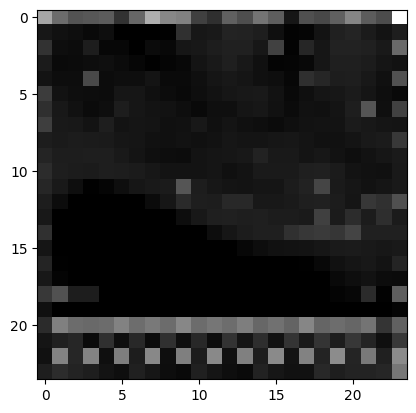

In [46]:
import matplotlib.pyplot as plt
c_i = 35
z_i = 10
plt.imshow(block22_se[c_i, z_i, :, :].cpu().numpy(), cmap='gray')

In [7]:
feat1 = features['out'][0]
feat2 = features['out'][1]
feat3 = features['out'][2]
feat4 = features['out'][3]

block33_feat = features['out'][4]
block22_feat = features['out'][5]

head_cls_feat = features['out'][6]
head_reg_feat = features['out'][7]
head_offset_feat = features['out'][8]

Cls_feat = output['Cls']

In [47]:
bs_i = 0
feat1_i = feat1[bs_i]
feat2_i = feat2[bs_i]
feat3_i = feat3[bs_i]
feat4_i = feat4[bs_i]

block33_feat_i = block33_feat[bs_i]
block22_feat_i = block22_feat[bs_i]

head_cls_feat_i = head_cls_feat[bs_i]
head_reg_feat_i = head_reg_feat[bs_i]
head_offset_feat_i = head_offset_feat[bs_i]

Cls_feat_i = Cls_feat[bs_i]

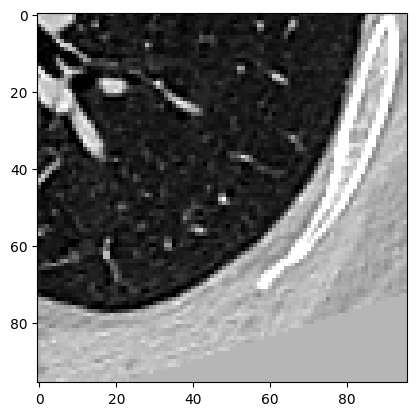

In [48]:
import matplotlib.pyplot as plt
z = 48
plt.imshow(image[bs_i, 0, z].cpu().numpy(), cmap='gray')

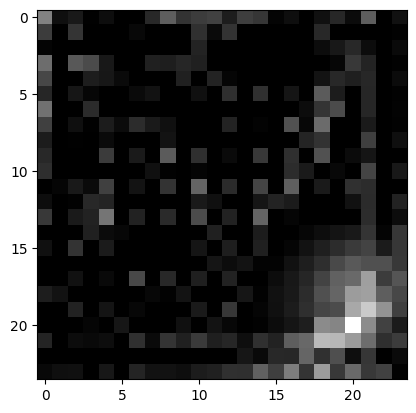

In [94]:
import matplotlib.pyplot as plt
z = 12
c_i = 29
plt.imshow(block22_feat_i[c_i, z].cpu().numpy(), cmap='gray')

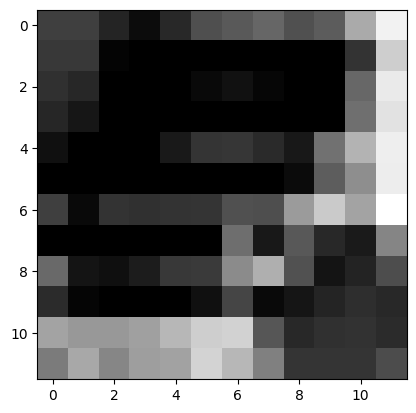

In [84]:
import matplotlib.pyplot as plt
z = 6
c_i = 6
plt.imshow(block33_feat_i[c_i, z].cpu().numpy(), cmap='gray')

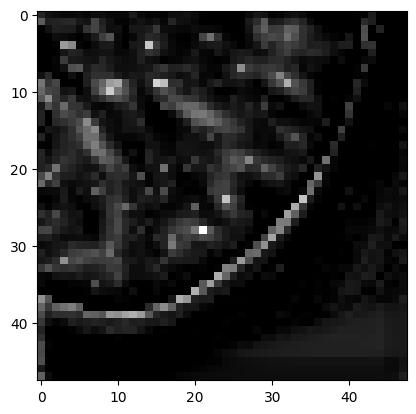

In [74]:
import matplotlib.pyplot as plt
z = 24
c_i = 46
plt.imshow(feat1_i[c_i, z].cpu().numpy(), cmap='gray')

In [ ]:
import matplotlib.pyplot as plt
z = 24
c_i = 40
plt.imshow(feat1_i[c_i, z].cpu().numpy(), cmap='gray')

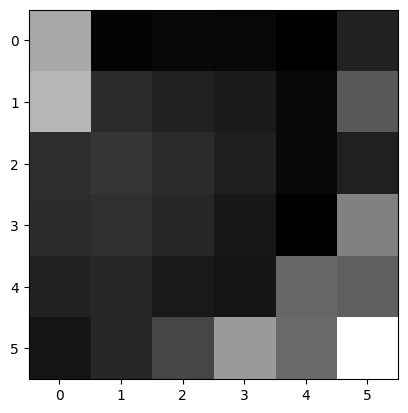

In [51]:
import matplotlib.pyplot as plt
z = 3
c_i = 96
plt.imshow(feat4_i[c_i, z].cpu().numpy(), cmap='gray')

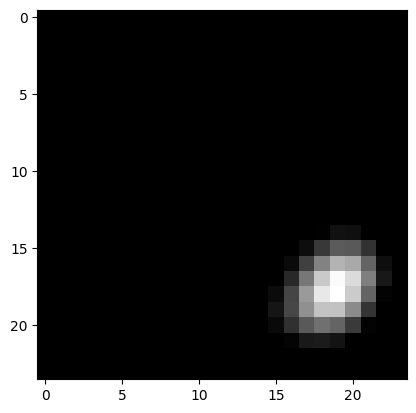

In [56]:
import matplotlib.pyplot as plt
z = 12
c_i = 29
plt.imshow(head_cls_feat_i[c_i, z].cpu().numpy(), cmap='gray')

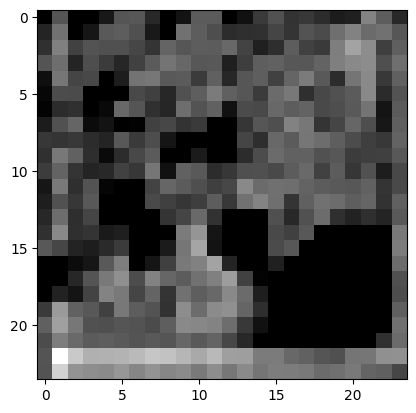

In [57]:
import matplotlib.pyplot as plt
z = 12
c_i = 15
plt.imshow(head_reg_feat_i[c_i, z].cpu().numpy(), cmap='gray')

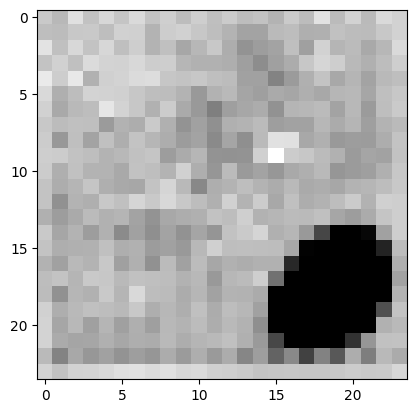

In [73]:
import matplotlib.pyplot as plt
z = 10
c_i = 15
plt.imshow(head_offset_feat_i[c_i, z].cpu().numpy(), cmap='gray')

In [71]:
(head_offset_feat_i[91, 12] - head_offset_feat_i[94, 12]).abs().sum()

tensor(13.6008, device='cuda:0')

In [65]:
(head_offset_feat_i[91, 12] - head_offset_feat_i[92, 12]).abs().sum()

tensor(14.0921, device='cuda:0')

In [ ]:
import matplotlib.pyplot as plt
z = 10
plt.imshow(Cls_feat_i[0, z].cpu().numpy(), cmap='gray')

In [ ]:
import matplotlib.pyplot as plt
z = 12
c_i = 12
plt.imshow(head0_feat_i[c_i, z].cpu().numpy(), cmap='gray')

In [ ]:
import matplotlib.pyplot as plt
z = 12
c_i = 22
plt.imshow(head_o_feat_i[c_i, z].cpu().numpy(), cmap='gray')

In [ ]:
import matplotlib.pyplot as plt
z = 12
c_i = 46
plt.imshow(head_r_feat_i[c_i, z].cpu().numpy(), cmap='gray')

In [ ]:
head_r_feat_i[c_i, z]